# Inputs


In [3]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import json
import csv
import pandas as pd
import matplotlib.pyplot as plt


# Setting Up Entries


In [4]:
json_file_path = "dev_results.json"
tsv_file_path = "dev.tsv"


In [16]:
# Load JSON file
with open(json_file_path, "r") as f:
    data_json = json.load(f)

# Load TSV file
data_tsv = []
with open(tsv_file_path, "r") as f:
    reader = csv.DictReader(f, delimiter='\t')
    for row in reader:
        data_tsv.append(row)

# Combine data
combined_data = []
for point in data_json["data_points"]:
    for row in data_tsv:
        if point["id"] == int(row["par_id"]):
            combined_data.append(
                {
                    "id": point["id"],
                    "keyword": row["keyword"],
                    "country_code": row["country"],
                    "keyword": row["keyword"],
                    "text": row["text"],
                    "target": point["target"],
                    "prediction": point["prediction"],
                    "orig_label": row["orig_label"]
                }
            )


print(len(combined_data))
print(combined_data[0])


2093
{'id': 107, 'keyword': 'homeless', 'country_code': 'ke', 'text': 'His present " chambers " may be quite humble , but Shiyani has the tiny space very neatly organized and clean . Many people pass him by but do not manage to see him , because the space is partially hidden behind trees , which gives him a relative privacy . " There are many homeless sleeping around the station , " Captain Xoli Mbele , from the nearby Johannesburg Central Police station said .', 'target': 1, 'prediction': 0, 'orig_label': '3'}


In [7]:
mismatched_entries = [entry for entry in combined_data if entry["target"] != entry["prediction"]]
false_positives = [dp for dp in combined_data if dp["target"] == 0 and dp["prediction"] == 1]
false_negatives = [dp for dp in combined_data if dp["target"] == 1 and dp["prediction"] == 0]

print(f"Total mismatched: {len(mismatched_entries)}")
print(f"\t FP: {len(false_positives)}")
print(f"\t FN: {len(false_negatives)}")


Total mismatched: 145
	 FP: 73
	 FN: 72


# Analysis of Length of Text


In [8]:
# Define the bin edges for the text length buckets
bin_edges = [i for i in range(0, 1050, 50)] + [float("inf")]

# Create a DataFrame with columns for the text length, false positives, and false negatives
text_length_df = pd.DataFrame(columns=["text_length", "false_positives", "false_negatives"])

# Iterate over the bins and count the false positives and false negatives in each bin
for i in range(len(bin_edges) - 1):
    # Define the current bin range
    bin_min = bin_edges[i]
    bin_max = bin_edges[i + 1]

    # Filter the combined_data array for entries with text lengths within the current bin range
    bin_data = [dp for dp in combined_data if bin_min <= len(dp["text"]) <= bin_max]

    # Count the false positives and false negatives in the current bin
    bin_false_positives = len(
        [dp for dp in bin_data if dp["target"] == 0 and dp["prediction"] == 1]
    )
    bin_false_negatives = len(
        [dp for dp in bin_data if dp["target"] == 1 and dp["prediction"] == 0]
    )

    # Append the counts to the DataFrame
    text_length_df = text_length_df.append(
        {
            "text_length": f"{bin_min}-{bin_max}",
            "false_positives": bin_false_positives,
            "false_negatives": bin_false_negatives,
        },
        ignore_index=True,
    )

# Print the resulting DataFrame
print(text_length_df)


   text_length false_positives false_negatives
0         0-50               1               0
1       50-100               6               4
2      100-150               8               6
3      150-200              13              11
4      200-250               4              13
5      250-300              10               7
6      300-350               9               3
7      350-400               9              10
8      400-450               4               7
9      450-500               3               3
10     500-550               0               3
11     550-600               2               2
12     600-650               2               1
13     650-700               0               1
14     700-750               1               0
15     750-800               2               0
16     800-850               0               0
17     850-900               0               0
18     900-950               0               1
19    950-1000               0               0
20    1000-in

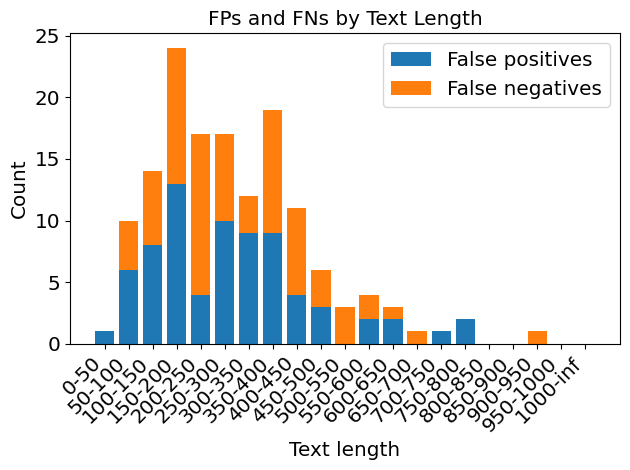

In [9]:
# Set the x-axis labels to the bin ranges
x_labels = text_length_df["text_length"].values

# Create a bar chart of the false positives and false negatives
plt.bar(x_labels, text_length_df["false_positives"].values, label="False positives")
plt.bar(
    x_labels,
    text_length_df["false_negatives"].values,
    bottom=text_length_df["false_positives"].values,
    label="False negatives",
)

# Increase bar chart size
# plt.rcParams["figure.figsize"] = (10, 6)

# Add labels and legend
plt.xlabel("Text length", fontsize="x-large")
plt.ylabel("Count", fontsize="x-large")
plt.title("FPs and FNs by Text Length", fontsize="x-large")

plt.xticks(fontsize="x-large", rotation=45, ha="right")
plt.yticks(fontsize="x-large")

plt.legend(fontsize="x-large")

plt.tight_layout()
plt.show()


In [10]:
# Create a DataFrame with columns for the country, false positives, and false negatives
country_df = pd.DataFrame(columns=["country_code", "false_positives", "false_negatives"])

# Iterate over the unique countries and count the false positives and false negatives in each country
unique_countries = set(dp["country_code"] for dp in combined_data)
for country in unique_countries:
    # Filter the combined_data array for entries with the current country
    country_data = [dp for dp in combined_data if dp["country_code"] == country]

    # Count the false positives and false negatives in the current country
    country_false_positives = len(
        [dp for dp in country_data if dp["target"] == 0 and dp["prediction"] == 1]
    )
    country_false_negatives = len(
        [dp for dp in country_data if dp["target"] == 1 and dp["prediction"] == 0]
    )

    # Append the counts to the DataFrame
    country_df = country_df.append(
        {
            "country_code": country,
            "false_positives": country_false_positives,
            "false_negatives": country_false_negatives,
        },
        ignore_index=True,
    )

# Print the resulting DataFrame
print(country_df)


   country_code false_positives false_negatives
0            bd               4               4
1            ng               7               5
2            au               5               2
3            nz               1               4
4            ca               1               2
5            ke               7               2
6            jm               7               1
7            lk               4               4
8            za               5               4
9            us               6               3
10           in               2               3
11           tz               2               5
12           pk               4               6
13           ie               2               3
14           sg               2               2
15           hk               0               2
16           gb               3               4
17           ph               7               7
18           gh               1               6
19           my               3         

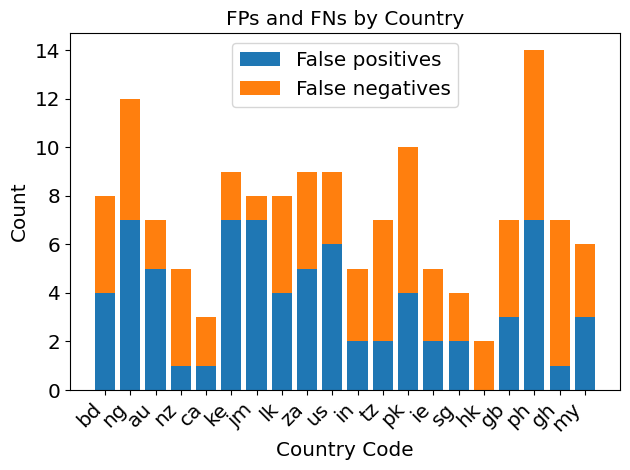

In [11]:
# Set the x-axis labels to the bin ranges
x_labels = country_df["country_code"].values

# Create a bar chart of the false positives and false negatives
plt.bar(x_labels, country_df["false_positives"].values, label="False positives")
plt.bar(
    x_labels,
    country_df["false_negatives"].values,
    bottom=country_df["false_positives"].values,
    label="False negatives",
)

# Increase bar chart size
plt.rcParams["figure.figsize"] = (10, 6)

# Add labels and legend
plt.xlabel("Country Code", fontsize="x-large")
plt.ylabel("Count", fontsize="x-large")
plt.title("FPs and FNs by Country", fontsize="x-large")

plt.xticks(fontsize="x-large", rotation=45, ha="right")
plt.yticks(fontsize="x-large")

plt.legend(fontsize="x-large")

plt.tight_layout()
plt.show()


In [12]:
# Create a DataFrame with columns for the orig_label, false positives, and false negatives
orig_label_df = pd.DataFrame(columns=["orig_label", "false_positives", "false_negatives"])

# Iterate over the unique orig_labels and count the false positives and false negatives in each orig_label
unique_orig_labels = set(dp["orig_label"] for dp in combined_data)
for orig_label in unique_orig_labels:
    # Filter the combined_data array for entries with the current orig_label
    orig_label_data = [dp for dp in combined_data if dp["orig_label"] == orig_label]

    # Count the false positives and false negatives in the current orig_label
    orig_label_false_positives = len(
        [dp for dp in orig_label_data if dp["target"] == 0 and dp["prediction"] == 1]
    )
    orig_label_false_negatives = len(
        [dp for dp in orig_label_data if dp["target"] == 1 and dp["prediction"] == 0]
    )

    # Append the counts to the DataFrame
    orig_label_df = orig_label_df.append(
        {
            "orig_label": orig_label,
            "false_positives": orig_label_false_positives,
            "false_negatives": orig_label_false_negatives,
        },
        ignore_index=True,
    )

# Print the resulting DataFrame
print(orig_label_df)


  orig_label false_positives false_negatives
0          2               1               0
1          1              34               0
2          4               0              24
3          3               0              48
4          0              38               0


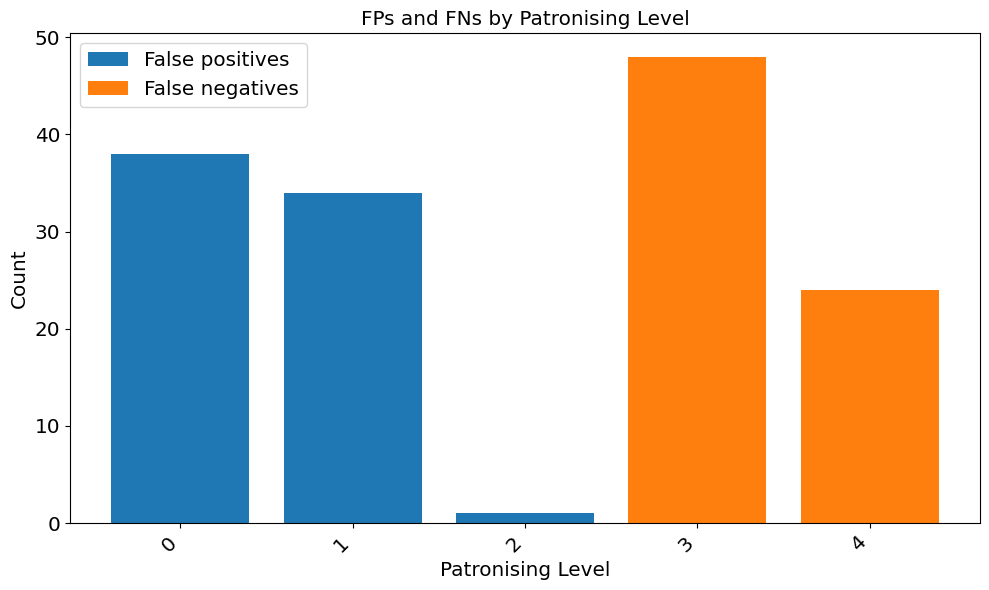

In [18]:
# Set the x-axis labels to the bin ranges
orig_label_df = orig_label_df.sort_values("orig_label")
x_labels = orig_label_df["orig_label"].values

# Create a bar chart of the false positives and false negatives
plt.bar(x_labels, orig_label_df["false_positives"].values, label="False positives")
plt.bar(
    x_labels,
    orig_label_df["false_negatives"].values,
    bottom=orig_label_df["false_positives"].values,
    label="False negatives",
)

# Increase bar chart size
plt.rcParams["figure.figsize"] = (10, 6)

# Add labels and legend
plt.xlabel("Patronising Level", fontsize="x-large")
plt.ylabel("Count", fontsize="x-large")
plt.title("FPs and FNs by Patronising Level", fontsize="x-large")

plt.xticks(fontsize="x-large", rotation=45, ha="right")
plt.yticks(fontsize="x-large")

plt.legend(fontsize="x-large")

plt.tight_layout()
plt.show()


In [19]:
# Create a DataFrame with columns for the keyword, false positives, and false negatives
keyword_df = pd.DataFrame(columns=["keyword", "false_positives", "false_negatives"])

# Iterate over the unique keywords and count the false positives and false negatives in each keyword
unique_keywords = set(dp["keyword"] for dp in combined_data)
for keyword in unique_keywords:
    # Filter the combined_data array for entries with the current keyword
    keyword_data = [dp for dp in combined_data if dp["keyword"] == keyword]

    # Count the false positives and false negatives in the current keyword
    keyword_false_positives = len(
        [dp for dp in keyword_data if dp["target"] == 0 and dp["prediction"] == 1]
    )
    keyword_false_negatives = len(
        [dp for dp in keyword_data if dp["target"] == 1 and dp["prediction"] == 0]
    )

    # Append the counts to the DataFrame
    keyword_df = keyword_df.append(
        {
            "keyword": keyword,
            "false_positives": keyword_false_positives,
            "false_negatives": keyword_false_negatives,
        },
        ignore_index=True,
    )

# Print the resulting DataFrame
print(keyword_df)


         keyword false_positives false_negatives
0       hopeless              14              12
1          women               3               8
2  poor-families              10              17
3        in-need              11               3
4        refugee               8               1
5       homeless              12              10
6        migrant               1               2
7      immigrant               2               5
8     vulnerable               9               8
9       disabled               3               6


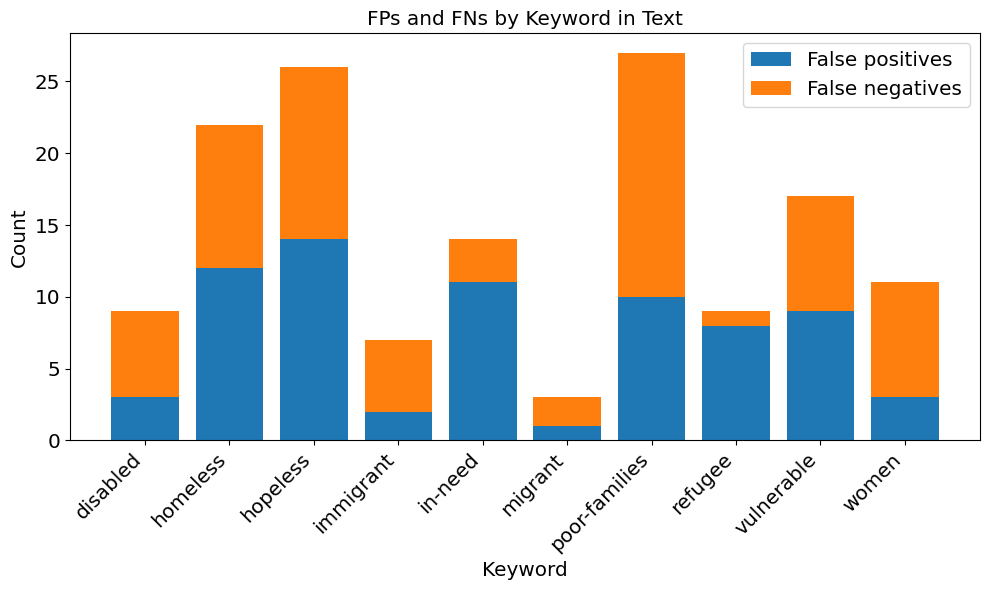

In [21]:
# Set the x-axis labels to the bin ranges
keyword_df = keyword_df.sort_values("keyword")
x_labels = keyword_df["keyword"].values

# Create a bar chart of the false positives and false negatives
plt.bar(x_labels, keyword_df["false_positives"].values, label="False positives")
plt.bar(
    x_labels,
    keyword_df["false_negatives"].values,
    bottom=keyword_df["false_positives"].values,
    label="False negatives",
)

# Increase bar chart size
plt.rcParams["figure.figsize"] = (10, 6)

# Add labels and legend
plt.xlabel("Keyword", fontsize="x-large")
plt.ylabel("Count", fontsize="x-large")
plt.title("FPs and FNs by Keyword in Text", fontsize="x-large")

plt.xticks(fontsize="x-large", rotation=45, ha="right")
plt.yticks(fontsize="x-large")

plt.legend(fontsize="x-large")

plt.tight_layout()
plt.show()
